In [53]:
import logging

# logging.basicConfig(
#     level=logging.DEBUG,
#     format='%(asctime)s - %(levelname)s - %(message)s'
# )

logger = logging.getLogger("dicris")
logger.setLevel(logging.DEBUG)

# Create handlers
console_handler = logging.StreamHandler()
file_handler = logging.FileHandler("dicris.log")

# Set levels for handlers
console_handler.setLevel(logging.DEBUG)
file_handler.setLevel(logging.DEBUG)

# Create formatters and add to handlers
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
console_handler.setFormatter(formatter)
file_handler.setFormatter(formatter)

# Add handlers to logger
logger.addHandler(console_handler)
# logger.addHandler(file_handler)

import contextily as ctx
import geocube
import geopandas as gpd
import io
import json
import keras
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np
import os
import pandas as pd
import pathlib
import rasterio
import re
import seaborn as sns
import shapely
import spectral
import tempfile
import tensorflow as tf
import zipfile

from affine import Affine
from functools import partial
from geocube.api.core import make_geocube
from IPython.display import JSON, HTML
from keras.utils import to_categorical
from matplotlib.colors import to_rgba
from pyproj import CRS
from rasterio.io import MemoryFile
from shapely.affinity import affine_transform
from shapely.geometry import box, mapping, Point, Polygon
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder
from spectral import envi
from tensorflow.keras import layers
from tqdm.notebook import trange, tqdm

# Make numpy values easier to read.
np.set_printoptions(precision=6, suppress=True)

%matplotlib inline

### `BSQ` format - Band Sequential (bands, rows, cols)

```
Band 1:
  Line 1: pixel(1,1,1), pixel(1,2,1), ..., pixel(1,512,1)
  Line 2: ...
  ...
  Line 512: ...
Band 2:
  Line 1: pixel(1,1,2), pixel(1,2,2), ...
...
Band 224:
  Line 512: ...
```

In [101]:
class Const():

    class ENVI():
        COORDINATE_SYSTEM_STRING = 'coordinate system string'
        BANDS = 'bands'
        LINES = 'lines'
        MAP_INFO = 'map info'
        SAMPLES = 'samples'
        
        class MapInfo():
            PROJECTION = 0
            X_REF = 1
            Y_REF = 2
            PIXEL_EASTING = 3
            PIXEL_NORTHING = 4
            PIXEL_SIZE_X = 5
            PIXEL_SIZE_Y = 6


def find_hyperspectral_files(dir):
    """
    Recursively searches a directory for hyperspectral image files with associated ENVI header files.

    This function looks for files with the following extensions: `.bsq`, `.img`, `.zip`, and `.hdr`.
    It identifies valid hyperspectral data files only if a corresponding `.hdr` file exists alongside each data file,
    or is found inside a `.zip` archive.

    Parameters:
    -----------
    dir : str or pathlib.Path
        The root directory to search recursively for hyperspectral files.

    Returns:
    --------
    list of pathlib.Path
        A sorted list of valid hyperspectral data files (excluding `.hdr`),
        each of which has an associated `.hdr` file.

    Notes:
    ------
    - Files with extensions `.bsq`, `.img`, and `.zip` are considered data files.
    - `.hdr` files are matched by filename (minus extension) to confirm a valid pair.
    - If a `.zip` file contains an `.hdr` file, it's considered a valid pair.
    - A warning is logged for each data file that does not have a corresponding `.hdr`.

    Example:
    --------
    >>> find_hyperspectral_files("/path/to/dataset")
    [PosixPath('/path/to/dataset/sample1.bsq'), PosixPath('/path/to/dataset/sample2.img')]
    """
    files = [f for f in pathlib.Path(dir).rglob('*') if f.suffix.lower().endswith(('.bsq', '.hdr', '.img', '.zip'))]
    data_files = [f for f in files if not f.suffix.lower().endswith('.hdr')]
    hdr_files = [f.as_posix()[:-4] for f in files if f.suffix.lower().endswith('.hdr')]
    files_ret = []
    with tqdm(data_files) as pbar:
        for f in pbar:
            pbar.set_description(f'Checking .hdr exists for: {f}')
            hdr_file = f'{f.as_posix()[:-4]}'
            is_f_added = False
            for i in range(len(hdr_files)):
                if hdr_files[i] == hdr_file:
                    files_ret.append(f)
                    is_f_added = True
                    del hdr_files[i]
                    break
            if not is_f_added and f.suffix.lower().endswith('.zip'):
                with zipfile.ZipFile(f, 'r') as zip_ref:
                    for name in zip_ref.namelist():
                        if name.lower().endswith('.hdr'):
                            files_ret.append(f)
                            is_f_added = True
                            break
            if not is_f_added:
                logger.warning(f'ENVI header file not found for {f}')
    files_ret = sorted(files_ret, key=lambda k: k.as_posix().lower())
    return files_ret


def read_envi_hdr(file):
    logger.debug(f'loading ENVI hdr: {file}')
    return envi.read_envi_header(file)


def create_tmp_file(content, suffix):
    with tempfile.NamedTemporaryFile(mode='wb', delete=False, suffix=suffix) as temp_hdr:
        temp_hdr.write(content)
        return temp_hdr.name


def read_bsq(file, hdr=None, dtype=np.float32):
    """
    Reads a hyperspectral image stored in ENVI BSQ (Band Sequential) format, with optional support for `.zip` archives.

    Parameters:
    -----------
    file : str or pathlib.Path
        Path to the `.bsq`, `.img`, or `.zip` file containing the hyperspectral image data.

    hdr : dict, optional
        Parsed ENVI header dictionary. If not provided, the function will attempt to locate and read
        a `.hdr` file with the same base name as the input file or from within a `.zip` archive.

    dtype : numpy dtype, optional (default: np.float32)
        Data type used to interpret the binary image data.

    Returns:
    --------
    tuple of (dict, numpy.ndarray)
        - hdr: The parsed ENVI header as a dictionary.
        - data: A NumPy array of shape (lines, samples, bands) containing the hyperspectral image data.

    Raises:
    -------
    Exception
        If the header or data file cannot be loaded successfully.

    Notes:
    ------
    - If the image file is a `.zip`, the function searches for one `.hdr` and one image file (`.bsq` or `.img`) inside.
    - The data is reshaped according to the `bands`, `lines`, and `samples` specified in the header and transposed to
      the standard (lines, samples, bands) format.

    Example:
    --------
    >>> hdr, data = read_bsq("/path/to/image.bsq")
    >>> print(data.shape)
    (512, 512, 224)
    """
    data = None

    is_hdr_loaded = hdr is not None
    is_data_loaded = False

    file = file.as_posix() if isinstance(file, pathlib.Path) else file

    # try to locate the ENVI header file beside the image file
    if not is_hdr_loaded:
        hdr_file = re.sub(r'(?i)\.(bsq|img|zip)$', '.hdr', file)
        if os.path.isfile(hdr_file):
            hdr = read_envi_hdr(hdr_file)
            is_hdr_loaded = True

    if file.lower().endswith('zip'):
        with zipfile.ZipFile(file, 'r') as zip_ref:
            for name in zip_ref.namelist():
                if not is_hdr_loaded and name.lower().endswith('.hdr'):
                    # try to load the ENVI header file from the zip
                    with zip_ref.open(name) as f:
                        hdr_tmp_file = create_tmp_file(f.read(), '.hdr')
                        hdr = read_envi_hdr(hdr_tmp_file)
                        os.remove(hdr_tmp_file)
                        is_hdr_loaded = True
                elif not is_data_loaded and name.lower().endswith(('.img', '.bsq')):
                    with zip_ref.open(name) as f:
                        file_data = f.read()  # this is a bytes object
                        data = np.frombuffer(file_data, dtype=dtype)
                        is_data_loaded = True
                if is_hdr_loaded and is_data_loaded:
                    break
    else:
        with open(file, 'rb') as f:
            file_data = f.read()  # this is a bytes object
            data = np.frombuffer(file_data, dtype=dtype)
            is_data_loaded = True

    if not is_hdr_loaded or not is_data_loaded:
        raise Exception(f'failed to load file f{file}') 
    
    bands = int(hdr[Const.ENVI.BANDS])
    lines = int(hdr[Const.ENVI.LINES])
    samples = int(hdr[Const.ENVI.SAMPLES])

    # Reshape to (bands, lines, samples) then transpose to (lines, samples, bands)
    data = data.reshape((bands, lines, samples)).transpose((1, 2, 0))
    
    return hdr, data


def get_nominal_bounds_from_hdr(hdr_dict):
    """
    Compute the nominal (full image) bounds in pixel coordinates from ENVI header metadata.

    Parameters:
        hdr_dict (dict): Parsed ENVI header.

    Returns:
        (xmin, ymin, xmax, ymax): Image bounds in pixel space.
    """
    width = int(hdr_dict[Const.ENVI.SAMPLES])   # columns
    height = int(hdr_dict[Const.ENVI.LINES])    # rows
    return (0, 0, width, height)


def get_crs_from_hdr(hdr_dict):
    """
    Extract the coordinate reference system (CRS) from an ENVI header dictionary.

    This function reads the 'coordinate system string' field from the ENVI header 
    and constructs a CRS object using its WKT representation.

    Parameters:
        hdr_dict (dict): Parsed ENVI header as a dictionary, where keys are header
                         field names and values are their corresponding entries.

    Returns:
        CRS: A pyproj CRS object created from the WKT string found in the header.

    Raises:
        KeyError: If the 'coordinate system string' field is missing from the header.
        CRSError: If the WKT string is invalid or cannot be parsed.
    """
    crs = CRS.from_wkt(', '.join(hdr_dict[Const.ENVI.COORDINATE_SYSTEM_STRING]))
    return crs


def get_geographic_bounds_from_hdr(hdr_dict):
    """
    Compute geographic bounds from ENVI header's map info.

    Returns:
        (xmin, ymax, xmax, ymin): Geographic extent
    """
    if Const.ENVI.MAP_INFO not in hdr_dict:
        raise ValueError("No map info found in header.")

    info = hdr_dict[Const.ENVI.MAP_INFO]

    ref_x = float(info[Const.ENVI.MapInfo.PIXEL_EASTING])
    ref_y = float(info[Const.ENVI.MapInfo.PIXEL_NORTHING])
    x_res = float(info[Const.ENVI.MapInfo.PIXEL_SIZE_X])
    y_res = float(info[Const.ENVI.MapInfo.PIXEL_SIZE_Y])
    samples = int(hdr_dict[Const.ENVI.SAMPLES])
    lines = int(hdr_dict[Const.ENVI.LINES])

    xmin = ref_x
    ymax = ref_y
    xmax = xmin + samples * x_res
    ymin = ymax - lines * y_res

    return (xmin, ymax, xmax, ymin)


def get_gdf_from_bounds(bounds, crs=None):
    coords = np.array(
        [
            (bounds[0], bounds[1]),
            (bounds[2], bounds[1]),
            (bounds[2], bounds[3]),
            (bounds[0], bounds[3])
        ]
    )
    polygon = Polygon(coords)
    gdf = gpd.GeoDataFrame(geometry=[polygon], crs=crs)
    return gdf

## Find hyperspectral data

In [3]:
data_dir = os.path.join('/tf/notebooks/data/Hyperspektral_data/HYSPED/')
files = find_hyperspectral_files(data_dir)
logger.info(f'files found: {len(files)}')

  0%|          | 0/189 [00:00<?, ?it/s]

2025-05-28 14:02:22,386 - dicris - INFO - files found: 189


## Read data

In [4]:
file = files[0]
hdr, data = read_bsq(file)

display(JSON(hdr))
logger.info(f'data.shape: {data.shape}')

2025-05-28 14:02:22,587 - dicris - DEBUG - loading ENVI hdr: /tf/notebooks/data/Hyperspektral_data/HYSPED/01Let_25-08-2022/28-08-2022-POC_05_VS_geo.hdr
/usr/local/lib/python3.11/dist-packages/spectral/io/envi.py:187: UserWarning: Parameters with non-lowercase names encountered and converted to lowercase. To retain source file parameter name capitalization, set spectral.settings.envi_support_nonlowercase_params to True.
  warnings.warn(msg)


<IPython.core.display.JSON object>

2025-05-28 14:09:10,479 - dicris - INFO - data.shape: (3215, 4760, 474)


### Preview data

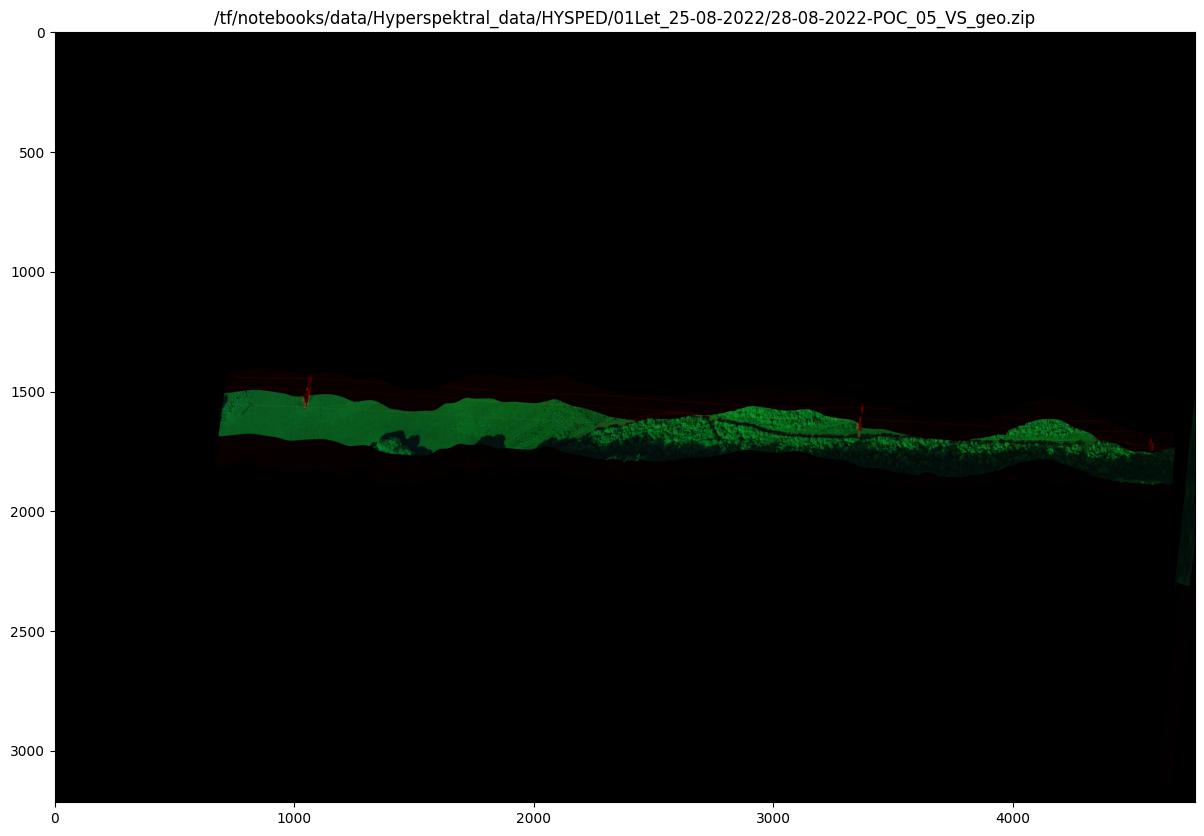

In [5]:
plt.figure(figsize=(20, 10))
plt.imshow(spectral.get_rgb(data))
plt.title(file)
plt.show()

### Preview data as RGB image with empty pixels in hi-contrast color

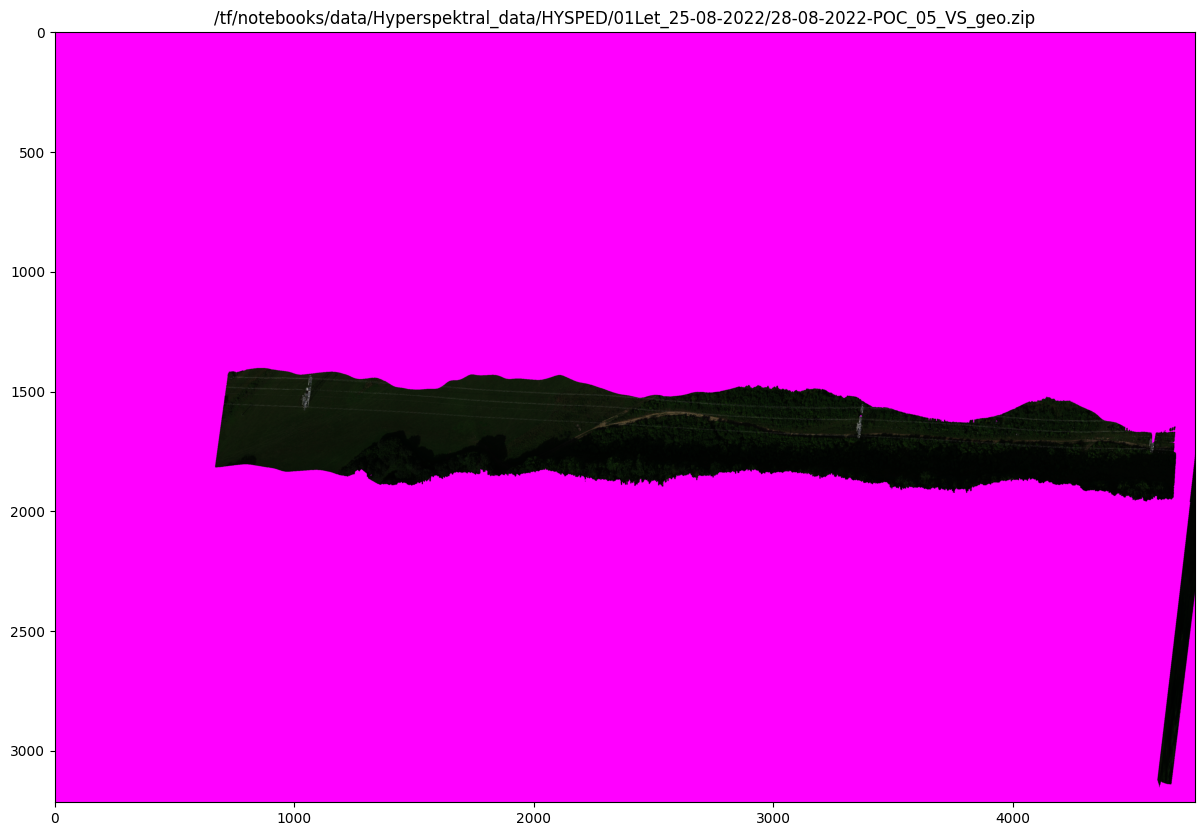

In [6]:
default_bands = [int(float(x)) for x in hdr['default bands']]

data_slice = data[:, :, default_bands]
img = spectral.get_rgb(data_slice)

# assign magenta color for zero values
img[np.all(img == 0, axis=-1)] = [1.0,0.0,1.0]

plt.figure(figsize=(20, 10))
plt.imshow(img)
plt.title(file)
plt.show()

## Transform 3D array to GeoDataFrame

### ENVI . `map info`

| Position | Meaning                                                         | Example value |
| -------- | --------------------------------------------------------------- | ------------- |
| 1        | Map projection name                                             | `UTM`         |
| 2        | Pixel x-coordinate of the upper-left corner pixel (usually 1.0) | `1.000`       |
| 3        | Pixel y-coordinate of the upper-left corner pixel (usually 1.0) | `1.000`       |
| 4        | X-coordinate of the center of the upper-left pixel in map units | `500000.0`    |
| 5        | Y-coordinate of the center of the upper-left pixel in map units | `4200000.0`   |
| 6        | Pixel size in the x-direction (map units per pixel)             | `5.0`         |
| 7        | Pixel size in the y-direction (map units per pixel)             | `5.0`         |
| 8        | UTM zone number (if using UTM projection)                       | `33`          |
| 9        | Hemisphere (if using UTM)                                       | `North`       |
| 10       | Datum or spheroid name                                          | `WGS-84`      |


#### map info ([source](https://www.nv5geospatialsoftware.com/docs/ENVIHeaderFiles.html))

Lists geographic information in the following order:

```
Projection name
Reference (tie point) pixel x location (in file coordinates)
Reference (tie point) pixel y location (in file coordinates)
Pixel easting
Pixel northing
x pixel size
y pixel size
Projection zone (UTM only)
North or South (UTM only)
Datum
Units
```

In [7]:
rows, cols, bands = data.shape

map_info = hdr[Const.ENVI.MAP_INFO]

x_min = np.float32(map_info[Const.ENVI.MapInfo.PIXEL_EASTING])
y_max = np.float32(map_info[Const.ENVI.MapInfo.PIXEL_NORTHING])
pixel_size_x = np.float32(map_info[Const.ENVI.MapInfo.PIXEL_SIZE_X])
pixel_size_y = np.float32(map_info[Const.ENVI.MapInfo.PIXEL_SIZE_Y])
crs = CRS.from_wkt(', '.join(hdr[Const.ENVI.COORDINATE_SYSTEM_STRING]))

transform = Affine.translation(x_min, y_max) * Affine.scale(pixel_size_x, -pixel_size_y)

# Create lists of points and spectral data:
points = []
spectral_data = []

with tqdm(total=rows*cols) as pbar:
    for r in range(rows):
        for c in range(cols):
            if np.all(data[r, c, :] == 0):
                pbar.update(1)
                continue
            # Calculate the geographic coordinates for each pixel center
            x, y = transform * (c + 0.5, r + 0.5)  
            points.append(shapely.geometry.Point(x, y))
            spectral_data.append(data[r, c, :])
            pbar.update(1)

spectral_data = np.array(spectral_data)  # shape (rows*cols, bands)

# Create column names for bands
band_columns = {f'band_{i+1}': spectral_data[:, i] for i in range(bands)}

# Create GeoDataFrame
gdf = gpd.GeoDataFrame(band_columns, geometry=points, crs=crs)

  0%|          | 0/15303400 [00:00<?, ?it/s]

In [8]:
print(gdf.head())

     band_1    band_2    band_3    band_4    band_5    band_6    band_7  \
0  0.005648  0.005510  0.006690  0.007072  0.006985  0.007020  0.007337   
1  0.005573  0.005907  0.006558  0.007006  0.006911  0.007387  0.007602   
2  0.006828  0.005808  0.006868  0.007424  0.007852  0.008128  0.008223   
3  0.006810  0.007613  0.007906  0.008262  0.008347  0.008984  0.008643   
4  0.006004  0.006056  0.007077  0.006776  0.007419  0.007192  0.007317   

     band_8    band_9   band_10  ...  band_466  band_467  band_468  band_469  \
0  0.007695  0.007153  0.008640  ...       0.0       0.0       0.0       0.0   
1  0.007210  0.006874  0.007911  ...       0.0       0.0       0.0       0.0   
2  0.008332  0.007522  0.008926  ...       0.0       0.0       0.0       0.0   
3  0.009029  0.008583  0.009723  ...       0.0       0.0       0.0       0.0   
4  0.007172  0.006721  0.008615  ...       0.0       0.0       0.0       0.0   

   band_470  band_471  band_472  band_473  band_474  \
0       0.0  

### Plot projected data

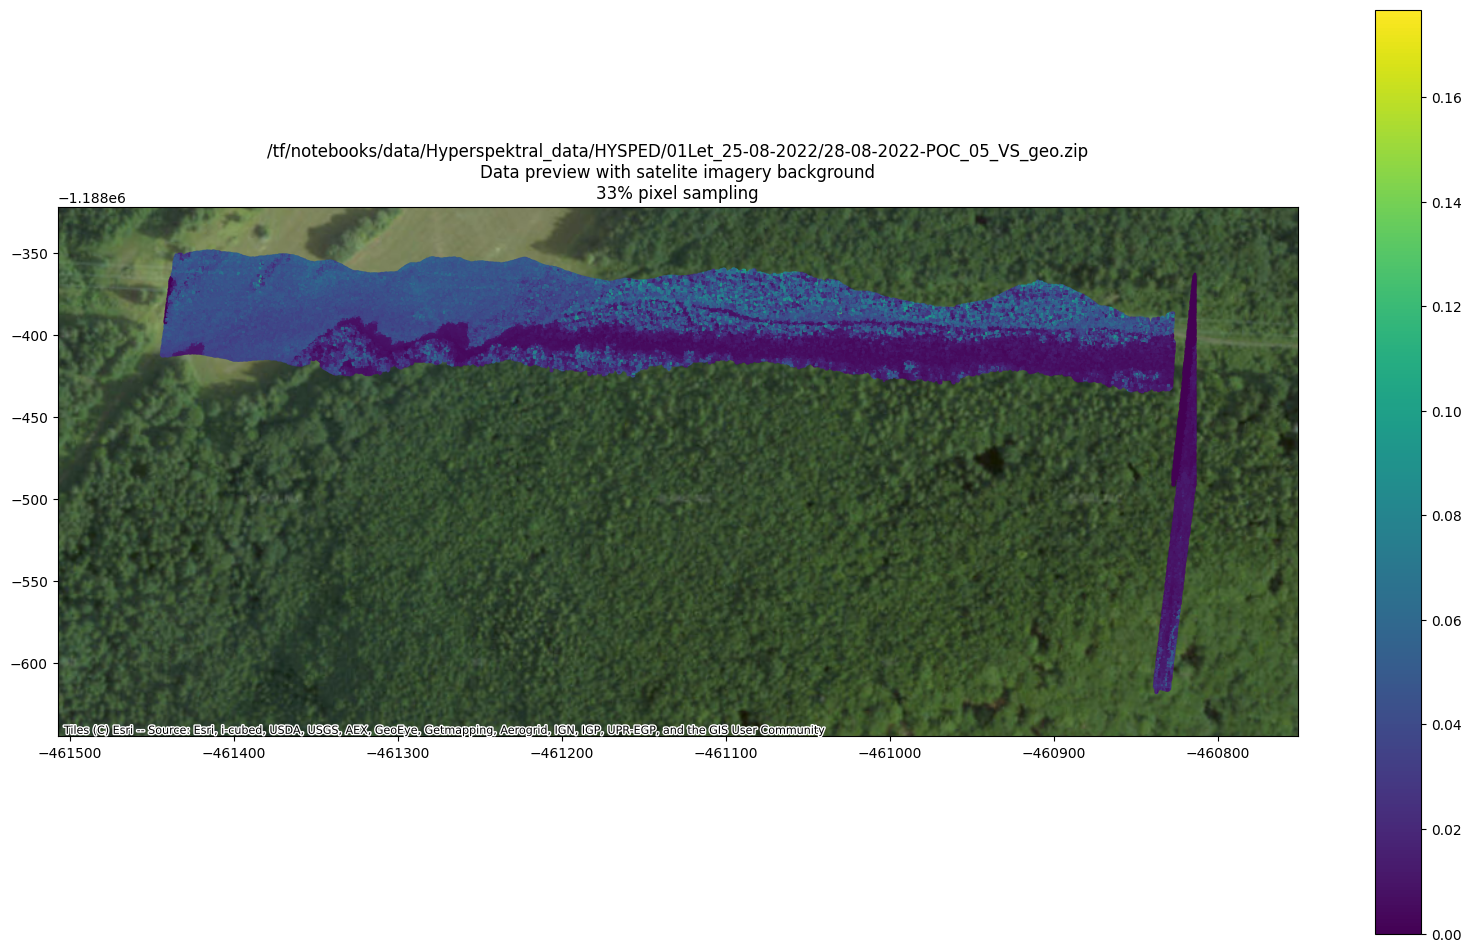

In [9]:
# select data to plot (sample to speed up)
frac=0.33
gdf_plot = gdf[['geometry', 'band_100']].sample(
    frac=frac,
    random_state=42
)

# zoom out
scale = 0.1
bbox = gdf_plot.total_bounds
dx = scale * np.abs(bbox[2]-bbox[0])
dy = scale * np.abs(bbox[3]-bbox[1])

# plot
f, ax = plt.subplots(1, figsize=(20,12))

# set boundaries
ax.set_xlim(bbox[0]-dx, bbox[2]+dx)
ax.set_ylim(bbox[1]-dy, bbox[3]+dy)

gdf_plot.plot(
    ax=ax,
    column='band_100',
    legend=True,
    alpha=0.75,
    marker=',',
    markersize=1
)

# basemap - satelite imagery
ctx.add_basemap(ax=ax, source=ctx.providers.Esri.WorldImagery, crs=crs)

plt.title('%s\nData preview with satelite imagery background\n%.0f%% pixel sampling' % (file, 100.0 * frac))
plt.show()

## Compute nominal (full) geographic bounds from ENVI header's map info.

**Note:** Empty (no-data) pixels are included in the image bounds, which may result in bounds larger than the actual data extent. To compute exact bounds, the image data must be read and analyzed.

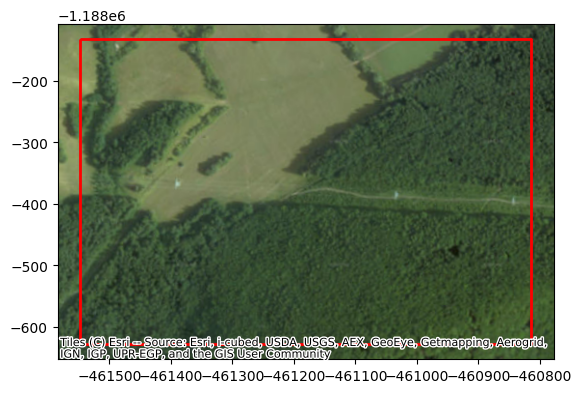

In [100]:
crs = get_crs_from_hdr(hdr)

gdf_bounds = get_gdf_from_bounds(
    get_geographic_bounds_from_hdr(hdr),
    crs
)

# Plot the polygon
ax = gdf_bounds.plot(edgecolor='red', facecolor='none', linewidth=2)

# basemap - satelite imagery
ctx.add_basemap(ax=ax, source=ctx.providers.Esri.WorldImagery, crs=crs)
plt.show()

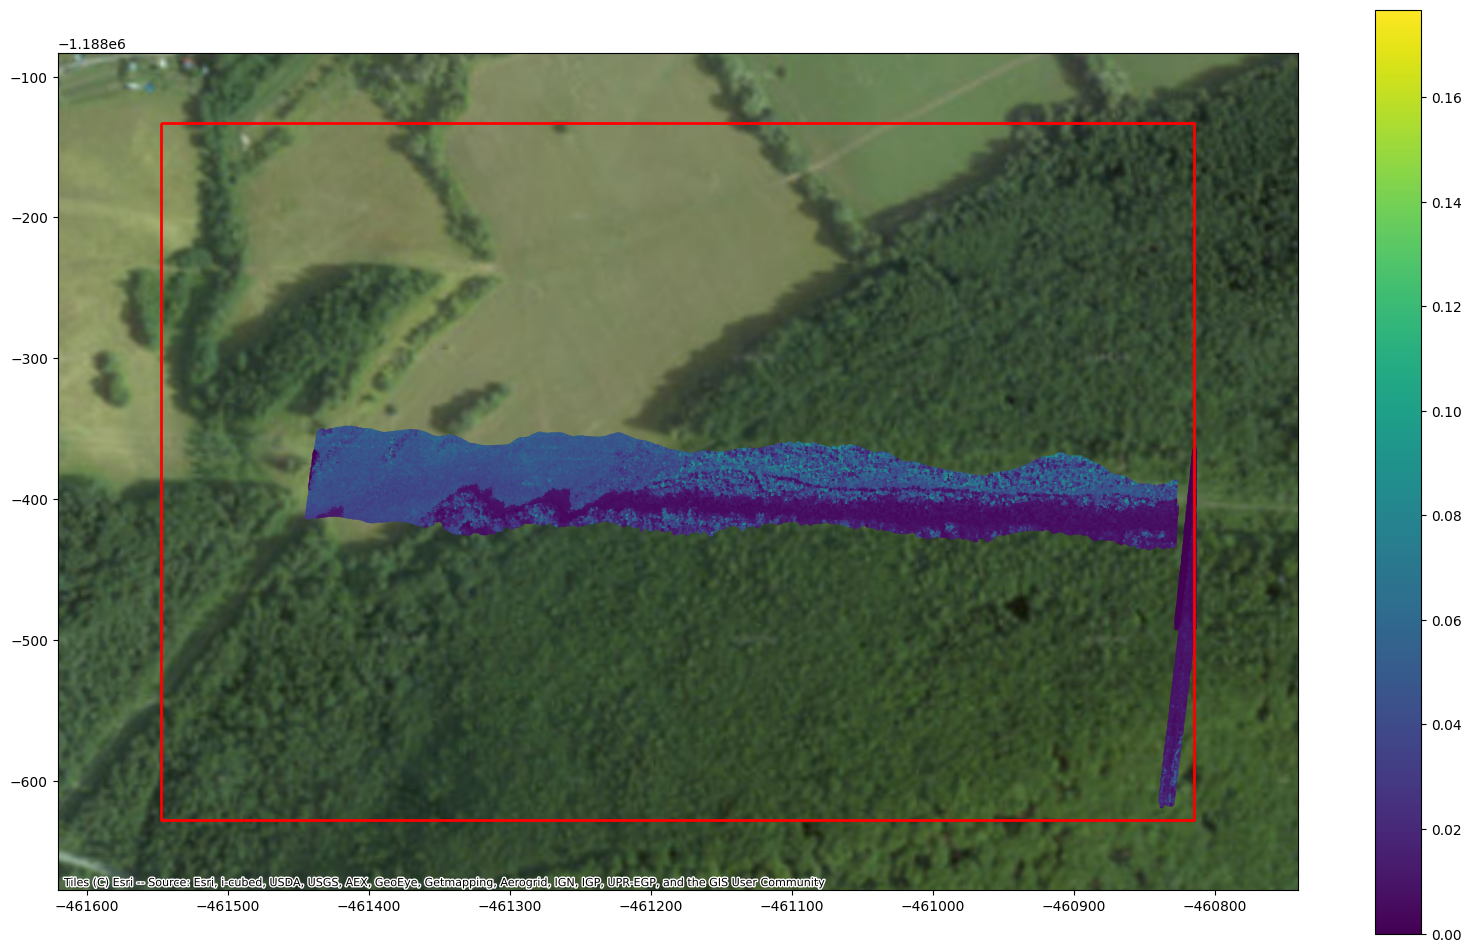

In [103]:
crs = get_crs_from_hdr(hdr)

# select data to plot (sample to speed up)
frac=0.33
gdf_plot = gdf[['geometry', 'band_100']].sample(
    frac=frac,
    random_state=42
)

# zoom out
scale = 0.1
bbox = polygon_gdf.total_bounds
dx = scale * np.abs(bbox[2]-bbox[0])
dy = scale * np.abs(bbox[3]-bbox[1])

# plot
f, ax = plt.subplots(1, figsize=(20,12))

# set boundaries
ax.set_xlim(bbox[0]-dx, bbox[2]+dx)
ax.set_ylim(bbox[1]-dy, bbox[3]+dy)

gdf_plot.plot(
    ax=ax,
    column='band_100',
    legend=True,
    alpha=0.75,
    marker=',',
    markersize=1
)

gdf_bounds = get_gdf_from_bounds(
    get_geographic_bounds_from_hdr(hdr),
    crs
)

# Plot the polygon
gdf_bounds.plot(ax=ax, edgecolor='red', facecolor='none', linewidth=2)

# basemap - satelite imagery
ctx.add_basemap(ax=ax, source=ctx.providers.Esri.WorldImagery, crs=crs)
plt.show()